In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from datasets import load_dataset
from timm import create_model
from transformers import ViTImageProcessor
from transformers import ViTConfig, ViTModel
import evaluate 
import numpy as np


In [9]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_name_or_path, return_tensors='pt')


In [10]:
# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)



In [11]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs


In [12]:
ds = load_dataset("C:/Tesis/DatasetBinario", num_proc=3)

Resolving data files:   0%|          | 0/20851 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/108 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1436 [00:00<?, ?it/s]

In [13]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 20851
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 108
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1436
    })
})

In [14]:
dataset_train = ds['train']
dataset_val = ds['validation']
num_classes = len(set(dataset_train['label']))
labels = ds['train'].features['label']
print(num_classes, labels)

2 ClassLabel(names=['Melanoma', 'No Melanoma'], id=None)


In [15]:
example = feature_extractor(dataset_train[0]['image'], return_tensors = 'pt')

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
def preprocess(batch):
    inputs = feature_extractor(batch['image'], return_tensors='pt').to(device)
    inputs['label'] = batch['label']
    return inputs

In [18]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_test = dataset_val.with_transform(preprocess)

In [19]:
print(prepared_train.features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Melanoma', 'No Melanoma'], id=None)}


In [20]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }


In [21]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
).to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
metric = evaluate.load("accuracy")

In [23]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir='./resultsViTBinary', 
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    save_steps=500,
    eval_steps=500,
    logging_steps=10,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_pin_memory=False
    
    )

C:\Users\abadd\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= prepared_train,
    eval_dataset= prepared_test,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    tokenizer=feature_extractor
)

C:\Users\abadd\AppData\Local\Temp\ipykernel_25872\1455688735.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
results = trainer.train()

  0%|          | 0/10428 [00:00<?, ?it/s]

{'loss': 0.6744, 'grad_norm': 1.654010534286499, 'learning_rate': 1.9980820866896817e-05, 'epoch': 0.0}
{'loss': 0.6752, 'grad_norm': 2.1206185817718506, 'learning_rate': 1.9961641733793635e-05, 'epoch': 0.01}
{'loss': 0.6345, 'grad_norm': 2.130784749984741, 'learning_rate': 1.994246260069045e-05, 'epoch': 0.01}
{'loss': 0.6473, 'grad_norm': 2.233139753341675, 'learning_rate': 1.9923283467587265e-05, 'epoch': 0.02}
{'loss': 0.6211, 'grad_norm': 2.426104784011841, 'learning_rate': 1.9904104334484084e-05, 'epoch': 0.02}
{'loss': 0.6329, 'grad_norm': 2.6524240970611572, 'learning_rate': 1.98849252013809e-05, 'epoch': 0.02}
{'loss': 0.6078, 'grad_norm': 2.9728901386260986, 'learning_rate': 1.9865746068277718e-05, 'epoch': 0.03}
{'loss': 0.6195, 'grad_norm': 3.1424577236175537, 'learning_rate': 1.9846566935174533e-05, 'epoch': 0.03}
{'loss': 0.5756, 'grad_norm': 3.0410590171813965, 'learning_rate': 1.9827387802071348e-05, 'epoch': 0.03}
{'loss': 0.577, 'grad_norm': 2.2300784587860107, 'lear

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3780050575733185, 'eval_accuracy': 0.8611111111111112, 'eval_runtime': 13.3772, 'eval_samples_per_second': 8.073, 'eval_steps_per_second': 0.523, 'epoch': 0.19}
{'loss': 0.5164, 'grad_norm': 2.280686855316162, 'learning_rate': 1.902186421173763e-05, 'epoch': 0.2}
{'loss': 0.4879, 'grad_norm': 5.4873552322387695, 'learning_rate': 1.9002685078634445e-05, 'epoch': 0.2}
{'loss': 0.558, 'grad_norm': 3.3039088249206543, 'learning_rate': 1.8983505945531264e-05, 'epoch': 0.2}
{'loss': 0.4763, 'grad_norm': 4.06662654876709, 'learning_rate': 1.896432681242808e-05, 'epoch': 0.21}
{'loss': 0.4265, 'grad_norm': 3.193070650100708, 'learning_rate': 1.8945147679324897e-05, 'epoch': 0.21}
{'loss': 0.4638, 'grad_norm': 5.0375213623046875, 'learning_rate': 1.8925968546221712e-05, 'epoch': 0.21}
{'loss': 0.3806, 'grad_norm': 5.01851224899292, 'learning_rate': 1.890678941311853e-05, 'epoch': 0.22}
{'loss': 0.4968, 'grad_norm': 3.6763322353363037, 'learning_rate': 1.8887610280015346e-05, 'ep

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.400713711977005, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 10.3425, 'eval_samples_per_second': 10.442, 'eval_steps_per_second': 0.677, 'epoch': 0.38}
{'loss': 0.4543, 'grad_norm': 3.2673304080963135, 'learning_rate': 1.8062907556578443e-05, 'epoch': 0.39}
{'loss': 0.5095, 'grad_norm': 5.045934677124023, 'learning_rate': 1.804372842347526e-05, 'epoch': 0.39}
{'loss': 0.4815, 'grad_norm': 4.081511974334717, 'learning_rate': 1.8024549290372077e-05, 'epoch': 0.4}
{'loss': 0.4142, 'grad_norm': 4.855908393859863, 'learning_rate': 1.8005370157268892e-05, 'epoch': 0.4}
{'loss': 0.3688, 'grad_norm': 4.206729888916016, 'learning_rate': 1.798619102416571e-05, 'epoch': 0.4}
{'loss': 0.4777, 'grad_norm': 1.7972731590270996, 'learning_rate': 1.7967011891062526e-05, 'epoch': 0.41}
{'loss': 0.4762, 'grad_norm': 7.002444267272949, 'learning_rate': 1.7947832757959344e-05, 'epoch': 0.41}
{'loss': 0.506, 'grad_norm': 6.149186134338379, 'learning_rate': 1.792865362485616e-05, 'ep

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5681933760643005, 'eval_accuracy': 0.7314814814814815, 'eval_runtime': 9.3164, 'eval_samples_per_second': 11.592, 'eval_steps_per_second': 0.751, 'epoch': 0.58}
{'loss': 0.4011, 'grad_norm': 3.3645620346069336, 'learning_rate': 1.7103950901419256e-05, 'epoch': 0.58}
{'loss': 0.3964, 'grad_norm': 4.130848407745361, 'learning_rate': 1.708477176831607e-05, 'epoch': 0.58}
{'loss': 0.3875, 'grad_norm': 1.1540842056274414, 'learning_rate': 1.706559263521289e-05, 'epoch': 0.59}
{'loss': 0.3974, 'grad_norm': 7.271149158477783, 'learning_rate': 1.7046413502109705e-05, 'epoch': 0.59}
{'loss': 0.3913, 'grad_norm': 6.260169506072998, 'learning_rate': 1.7027234369006524e-05, 'epoch': 0.59}
{'loss': 0.5022, 'grad_norm': 3.986598491668701, 'learning_rate': 1.700805523590334e-05, 'epoch': 0.6}
{'loss': 0.3145, 'grad_norm': 3.205718517303467, 'learning_rate': 1.6988876102800157e-05, 'epoch': 0.6}
{'loss': 0.3992, 'grad_norm': 5.789570331573486, 'learning_rate': 1.6969696969696972e-05, '

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5459250211715698, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 9.509, 'eval_samples_per_second': 11.358, 'eval_steps_per_second': 0.736, 'epoch': 0.77}
{'loss': 0.4044, 'grad_norm': 4.488623142242432, 'learning_rate': 1.614499424626007e-05, 'epoch': 0.77}
{'loss': 0.3596, 'grad_norm': 0.9099118709564209, 'learning_rate': 1.6125815113156885e-05, 'epoch': 0.77}
{'loss': 0.3143, 'grad_norm': 4.697057247161865, 'learning_rate': 1.6106635980053703e-05, 'epoch': 0.78}
{'loss': 0.3162, 'grad_norm': 10.567681312561035, 'learning_rate': 1.608745684695052e-05, 'epoch': 0.78}
{'loss': 0.416, 'grad_norm': 3.7173633575439453, 'learning_rate': 1.6068277713847337e-05, 'epoch': 0.79}
{'loss': 0.4593, 'grad_norm': 10.358061790466309, 'learning_rate': 1.6049098580744152e-05, 'epoch': 0.79}
{'loss': 0.3866, 'grad_norm': 4.39102029800415, 'learning_rate': 1.6029919447640967e-05, 'epoch': 0.79}
{'loss': 0.4709, 'grad_norm': 6.285432815551758, 'learning_rate': 1.6010740314537786e-05,

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.42372265458106995, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 9.1694, 'eval_samples_per_second': 11.778, 'eval_steps_per_second': 0.763, 'epoch': 0.96}
{'loss': 0.2712, 'grad_norm': 3.440399646759033, 'learning_rate': 1.5186037591100885e-05, 'epoch': 0.96}
{'loss': 0.3157, 'grad_norm': 3.4949676990509033, 'learning_rate': 1.51668584579977e-05, 'epoch': 0.97}
{'loss': 0.3999, 'grad_norm': 4.951318264007568, 'learning_rate': 1.5147679324894515e-05, 'epoch': 0.97}
{'loss': 0.5326, 'grad_norm': 9.653203010559082, 'learning_rate': 1.5128500191791333e-05, 'epoch': 0.97}
{'loss': 0.2789, 'grad_norm': 1.712977647781372, 'learning_rate': 1.5109321058688148e-05, 'epoch': 0.98}
{'loss': 0.4047, 'grad_norm': 4.4955573081970215, 'learning_rate': 1.5090141925584965e-05, 'epoch': 0.98}
{'loss': 0.2551, 'grad_norm': 4.070214748382568, 'learning_rate': 1.507096279248178e-05, 'epoch': 0.99}
{'loss': 0.3826, 'grad_norm': 3.242966413497925, 'learning_rate': 1.5051783659378599e-05

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5297947525978088, 'eval_accuracy': 0.75, 'eval_runtime': 9.3401, 'eval_samples_per_second': 11.563, 'eval_steps_per_second': 0.749, 'epoch': 1.15}
{'loss': 0.2294, 'grad_norm': 2.4858574867248535, 'learning_rate': 1.4227080935941698e-05, 'epoch': 1.15}
{'loss': 0.2061, 'grad_norm': 2.1236889362335205, 'learning_rate': 1.4207901802838513e-05, 'epoch': 1.16}
{'loss': 0.2865, 'grad_norm': 13.611586570739746, 'learning_rate': 1.4188722669735328e-05, 'epoch': 1.16}
{'loss': 0.3009, 'grad_norm': 6.334510803222656, 'learning_rate': 1.4169543536632145e-05, 'epoch': 1.17}
{'loss': 0.2933, 'grad_norm': 1.5485103130340576, 'learning_rate': 1.4150364403528962e-05, 'epoch': 1.17}
{'loss': 0.2287, 'grad_norm': 4.869540214538574, 'learning_rate': 1.4131185270425779e-05, 'epoch': 1.17}
{'loss': 0.2261, 'grad_norm': 2.8867554664611816, 'learning_rate': 1.4112006137322594e-05, 'epoch': 1.18}
{'loss': 0.2535, 'grad_norm': 5.850001335144043, 'learning_rate': 1.4092827004219412e-05, 'epoch'

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.8460211157798767, 'eval_accuracy': 0.6851851851851852, 'eval_runtime': 10.1318, 'eval_samples_per_second': 10.66, 'eval_steps_per_second': 0.691, 'epoch': 1.34}
{'loss': 0.3364, 'grad_norm': 1.732947826385498, 'learning_rate': 1.3268124280782511e-05, 'epoch': 1.35}
{'loss': 0.2182, 'grad_norm': 14.706263542175293, 'learning_rate': 1.3248945147679326e-05, 'epoch': 1.35}
{'loss': 0.4637, 'grad_norm': 12.265542984008789, 'learning_rate': 1.3229766014576141e-05, 'epoch': 1.35}
{'loss': 0.183, 'grad_norm': 8.969168663024902, 'learning_rate': 1.3210586881472958e-05, 'epoch': 1.36}
{'loss': 0.2348, 'grad_norm': 7.634190082550049, 'learning_rate': 1.3191407748369775e-05, 'epoch': 1.36}
{'loss': 0.3683, 'grad_norm': 2.5386857986450195, 'learning_rate': 1.3172228615266592e-05, 'epoch': 1.37}
{'loss': 0.2335, 'grad_norm': 1.4728387594223022, 'learning_rate': 1.3153049482163407e-05, 'epoch': 1.37}
{'loss': 0.2878, 'grad_norm': 10.974739074707031, 'learning_rate': 1.3133870349060222

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.4428214728832245, 'eval_accuracy': 0.8425925925925926, 'eval_runtime': 9.476, 'eval_samples_per_second': 11.397, 'eval_steps_per_second': 0.739, 'epoch': 1.53}
{'loss': 0.3503, 'grad_norm': 2.905151844024658, 'learning_rate': 1.2309167625623324e-05, 'epoch': 1.54}
{'loss': 0.3548, 'grad_norm': 20.184911727905273, 'learning_rate': 1.228998849252014e-05, 'epoch': 1.54}
{'loss': 0.3265, 'grad_norm': 4.348641872406006, 'learning_rate': 1.2270809359416955e-05, 'epoch': 1.55}
{'loss': 0.4562, 'grad_norm': 14.762227058410645, 'learning_rate': 1.2251630226313771e-05, 'epoch': 1.55}
{'loss': 0.2151, 'grad_norm': 10.902569770812988, 'learning_rate': 1.2232451093210588e-05, 'epoch': 1.55}
{'loss': 0.3099, 'grad_norm': 8.122758865356445, 'learning_rate': 1.2213271960107405e-05, 'epoch': 1.56}
{'loss': 0.3, 'grad_norm': 3.4519400596618652, 'learning_rate': 1.219409282700422e-05, 'epoch': 1.56}
{'loss': 0.2773, 'grad_norm': 0.23909693956375122, 'learning_rate': 1.2174913693901035e-05

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2920812964439392, 'eval_accuracy': 0.8796296296296297, 'eval_runtime': 9.9315, 'eval_samples_per_second': 10.875, 'eval_steps_per_second': 0.705, 'epoch': 1.73}
{'loss': 0.2352, 'grad_norm': 3.1780788898468018, 'learning_rate': 1.1350210970464134e-05, 'epoch': 1.73}
{'loss': 0.2367, 'grad_norm': 1.9590716361999512, 'learning_rate': 1.1331031837360953e-05, 'epoch': 1.73}
{'loss': 0.2289, 'grad_norm': 0.25272950530052185, 'learning_rate': 1.1311852704257768e-05, 'epoch': 1.74}
{'loss': 0.2101, 'grad_norm': 8.6296968460083, 'learning_rate': 1.1292673571154585e-05, 'epoch': 1.74}
{'loss': 0.2653, 'grad_norm': 15.994946479797363, 'learning_rate': 1.12734944380514e-05, 'epoch': 1.75}
{'loss': 0.2914, 'grad_norm': 1.773698091506958, 'learning_rate': 1.1254315304948218e-05, 'epoch': 1.75}
{'loss': 0.2145, 'grad_norm': 0.5356663465499878, 'learning_rate': 1.1235136171845033e-05, 'epoch': 1.75}
{'loss': 0.1572, 'grad_norm': 10.711459159851074, 'learning_rate': 1.1215957038741848e

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.373020201921463, 'eval_accuracy': 0.8796296296296297, 'eval_runtime': 9.5255, 'eval_samples_per_second': 11.338, 'eval_steps_per_second': 0.735, 'epoch': 1.92}
{'loss': 0.228, 'grad_norm': 9.756766319274902, 'learning_rate': 1.0391254315304949e-05, 'epoch': 1.92}
{'loss': 0.2005, 'grad_norm': 13.380814552307129, 'learning_rate': 1.0372075182201766e-05, 'epoch': 1.93}
{'loss': 0.1016, 'grad_norm': 8.003312110900879, 'learning_rate': 1.0352896049098583e-05, 'epoch': 1.93}
{'loss': 0.2321, 'grad_norm': 9.793625831604004, 'learning_rate': 1.0333716915995398e-05, 'epoch': 1.93}
{'loss': 0.1881, 'grad_norm': 24.986961364746094, 'learning_rate': 1.0314537782892213e-05, 'epoch': 1.94}
{'loss': 0.2649, 'grad_norm': 0.34415605664253235, 'learning_rate': 1.0295358649789031e-05, 'epoch': 1.94}
{'loss': 0.1778, 'grad_norm': 1.7811225652694702, 'learning_rate': 1.0276179516685847e-05, 'epoch': 1.94}
{'loss': 0.2087, 'grad_norm': 3.0753870010375977, 'learning_rate': 1.0257000383582663

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6080036759376526, 'eval_accuracy': 0.8240740740740741, 'eval_runtime': 9.3055, 'eval_samples_per_second': 11.606, 'eval_steps_per_second': 0.752, 'epoch': 2.11}
{'loss': 0.2344, 'grad_norm': 0.1609368771314621, 'learning_rate': 9.432297660145762e-06, 'epoch': 2.11}
{'loss': 0.2177, 'grad_norm': 2.323402166366577, 'learning_rate': 9.41311852704258e-06, 'epoch': 2.12}
{'loss': 0.108, 'grad_norm': 4.056036472320557, 'learning_rate': 9.393939393939396e-06, 'epoch': 2.12}
{'loss': 0.085, 'grad_norm': 0.24836866557598114, 'learning_rate': 9.374760260836211e-06, 'epoch': 2.13}
{'loss': 0.0149, 'grad_norm': 2.7938976287841797, 'learning_rate': 9.355581127733028e-06, 'epoch': 2.13}
{'loss': 0.266, 'grad_norm': 1.6446943283081055, 'learning_rate': 9.336401994629843e-06, 'epoch': 2.13}
{'loss': 0.0734, 'grad_norm': 0.3697373569011688, 'learning_rate': 9.31722286152666e-06, 'epoch': 2.14}
{'loss': 0.1338, 'grad_norm': 0.7156596779823303, 'learning_rate': 9.298043728423477e-06, 'epo

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5993662476539612, 'eval_accuracy': 0.7962962962962963, 'eval_runtime': 9.4824, 'eval_samples_per_second': 11.39, 'eval_steps_per_second': 0.738, 'epoch': 2.3}
{'loss': 0.1508, 'grad_norm': 0.07078567147254944, 'learning_rate': 8.473341004986576e-06, 'epoch': 2.31}
{'loss': 0.1486, 'grad_norm': 0.18128710985183716, 'learning_rate': 8.454161871883392e-06, 'epoch': 2.31}
{'loss': 0.1005, 'grad_norm': 1.624232292175293, 'learning_rate': 8.434982738780208e-06, 'epoch': 2.31}
{'loss': 0.1845, 'grad_norm': 5.474138259887695, 'learning_rate': 8.415803605677024e-06, 'epoch': 2.32}
{'loss': 0.294, 'grad_norm': 0.10810577869415283, 'learning_rate': 8.39662447257384e-06, 'epoch': 2.32}
{'loss': 0.179, 'grad_norm': 17.01466178894043, 'learning_rate': 8.377445339470656e-06, 'epoch': 2.32}
{'loss': 0.161, 'grad_norm': 52.175636291503906, 'learning_rate': 8.358266206367473e-06, 'epoch': 2.33}
{'loss': 0.1547, 'grad_norm': 4.878843784332275, 'learning_rate': 8.33908707326429e-06, 'epoch

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5541447997093201, 'eval_accuracy': 0.8240740740740741, 'eval_runtime': 9.4724, 'eval_samples_per_second': 11.402, 'eval_steps_per_second': 0.739, 'epoch': 2.49}
{'loss': 0.0473, 'grad_norm': 4.8821611404418945, 'learning_rate': 7.514384349827388e-06, 'epoch': 2.5}
{'loss': 0.0686, 'grad_norm': 1.5881664752960205, 'learning_rate': 7.495205216724205e-06, 'epoch': 2.5}
{'loss': 0.1131, 'grad_norm': 1.5163018703460693, 'learning_rate': 7.476026083621021e-06, 'epoch': 2.5}
{'loss': 0.0192, 'grad_norm': 0.17481482028961182, 'learning_rate': 7.456846950517838e-06, 'epoch': 2.51}
{'loss': 0.0981, 'grad_norm': 0.08104568719863892, 'learning_rate': 7.4376678174146535e-06, 'epoch': 2.51}
{'loss': 0.0469, 'grad_norm': 0.04922584444284439, 'learning_rate': 7.41848868431147e-06, 'epoch': 2.52}
{'loss': 0.1663, 'grad_norm': 4.7939229011535645, 'learning_rate': 7.3993095512082855e-06, 'epoch': 2.52}
{'loss': 0.2111, 'grad_norm': 27.327547073364258, 'learning_rate': 7.380130418105102e-0

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6513680219650269, 'eval_accuracy': 0.8055555555555556, 'eval_runtime': 9.4841, 'eval_samples_per_second': 11.387, 'eval_steps_per_second': 0.738, 'epoch': 2.69}
{'loss': 0.286, 'grad_norm': 27.621780395507812, 'learning_rate': 6.555427694668201e-06, 'epoch': 2.69}
{'loss': 0.1116, 'grad_norm': 0.06574835628271103, 'learning_rate': 6.536248561565017e-06, 'epoch': 2.69}
{'loss': 0.2715, 'grad_norm': 5.369364261627197, 'learning_rate': 6.517069428461834e-06, 'epoch': 2.7}
{'loss': 0.0719, 'grad_norm': 0.08032599091529846, 'learning_rate': 6.49789029535865e-06, 'epoch': 2.7}
{'loss': 0.1867, 'grad_norm': 7.615720748901367, 'learning_rate': 6.478711162255467e-06, 'epoch': 2.7}
{'loss': 0.2304, 'grad_norm': 1.4960224628448486, 'learning_rate': 6.459532029152284e-06, 'epoch': 2.71}
{'loss': 0.0088, 'grad_norm': 0.08142264932394028, 'learning_rate': 6.440352896049099e-06, 'epoch': 2.71}
{'loss': 0.1199, 'grad_norm': 1.1926429271697998, 'learning_rate': 6.4211737629459155e-06, '

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.4903107285499573, 'eval_accuracy': 0.8518518518518519, 'eval_runtime': 9.3894, 'eval_samples_per_second': 11.502, 'eval_steps_per_second': 0.746, 'epoch': 2.88}
{'loss': 0.2076, 'grad_norm': 59.49931716918945, 'learning_rate': 5.596471039509015e-06, 'epoch': 2.88}
{'loss': 0.097, 'grad_norm': 0.2787465453147888, 'learning_rate': 5.5772919064058304e-06, 'epoch': 2.88}
{'loss': 0.0752, 'grad_norm': 0.04375157505273819, 'learning_rate': 5.558112773302647e-06, 'epoch': 2.89}
{'loss': 0.1807, 'grad_norm': 0.292592316865921, 'learning_rate': 5.538933640199463e-06, 'epoch': 2.89}
{'loss': 0.1114, 'grad_norm': 15.856465339660645, 'learning_rate': 5.51975450709628e-06, 'epoch': 2.9}
{'loss': 0.1171, 'grad_norm': 0.05956294387578964, 'learning_rate': 5.500575373993096e-06, 'epoch': 2.9}
{'loss': 0.0879, 'grad_norm': 1.2402962446212769, 'learning_rate': 5.481396240889913e-06, 'epoch': 2.9}
{'loss': 0.12, 'grad_norm': 49.391841888427734, 'learning_rate': 5.462217107786728e-06, 'epo

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6785677671432495, 'eval_accuracy': 0.8240740740740741, 'eval_runtime': 9.2264, 'eval_samples_per_second': 11.706, 'eval_steps_per_second': 0.759, 'epoch': 3.07}
{'loss': 0.0614, 'grad_norm': 0.08005579560995102, 'learning_rate': 4.637514384349828e-06, 'epoch': 3.07}
{'loss': 0.041, 'grad_norm': 0.04331929236650467, 'learning_rate': 4.618335251246644e-06, 'epoch': 3.08}
{'loss': 0.0692, 'grad_norm': 0.34640005230903625, 'learning_rate': 4.5991561181434605e-06, 'epoch': 3.08}
{'loss': 0.0049, 'grad_norm': 0.06067270413041115, 'learning_rate': 4.5799769850402765e-06, 'epoch': 3.08}
{'loss': 0.0044, 'grad_norm': 0.07017267495393753, 'learning_rate': 4.560797851937092e-06, 'epoch': 3.09}
{'loss': 0.1348, 'grad_norm': 2.7784316539764404, 'learning_rate': 4.541618718833909e-06, 'epoch': 3.09}
{'loss': 0.0051, 'grad_norm': 0.049637921154499054, 'learning_rate': 4.522439585730725e-06, 'epoch': 3.1}
{'loss': 0.0386, 'grad_norm': 0.039350613951683044, 'learning_rate': 4.5032604526

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.7066799998283386, 'eval_accuracy': 0.8148148148148148, 'eval_runtime': 9.4489, 'eval_samples_per_second': 11.43, 'eval_steps_per_second': 0.741, 'epoch': 3.26}
{'loss': 0.0781, 'grad_norm': 1.9626119136810303, 'learning_rate': 3.678557729190641e-06, 'epoch': 3.26}
{'loss': 0.0862, 'grad_norm': 1.1706548929214478, 'learning_rate': 3.6593785960874573e-06, 'epoch': 3.27}
{'loss': 0.0258, 'grad_norm': 0.03678247705101967, 'learning_rate': 3.6401994629842733e-06, 'epoch': 3.27}
{'loss': 0.1074, 'grad_norm': 1.7814867496490479, 'learning_rate': 3.6210203298810897e-06, 'epoch': 3.28}
{'loss': 0.0776, 'grad_norm': 0.046181123703718185, 'learning_rate': 3.601841196777906e-06, 'epoch': 3.28}
{'loss': 0.0399, 'grad_norm': 0.2514030933380127, 'learning_rate': 3.5826620636747225e-06, 'epoch': 3.28}
{'loss': 0.0047, 'grad_norm': 0.08090579509735107, 'learning_rate': 3.5634829305715384e-06, 'epoch': 3.29}
{'loss': 0.0042, 'grad_norm': 0.04317251220345497, 'learning_rate': 3.5443037974

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.8695071935653687, 'eval_accuracy': 0.8148148148148148, 'eval_runtime': 9.5925, 'eval_samples_per_second': 11.259, 'eval_steps_per_second': 0.73, 'epoch': 3.45}
{'loss': 0.1286, 'grad_norm': 0.030384227633476257, 'learning_rate': 2.7196010740314538e-06, 'epoch': 3.46}
{'loss': 0.0762, 'grad_norm': 0.024274786934256554, 'learning_rate': 2.70042194092827e-06, 'epoch': 3.46}
{'loss': 0.062, 'grad_norm': 0.27304530143737793, 'learning_rate': 2.681242807825086e-06, 'epoch': 3.46}
{'loss': 0.0994, 'grad_norm': 0.040920671075582504, 'learning_rate': 2.6620636747219025e-06, 'epoch': 3.47}
{'loss': 0.0737, 'grad_norm': 0.04206251725554466, 'learning_rate': 2.6428845416187193e-06, 'epoch': 3.47}
{'loss': 0.0825, 'grad_norm': 51.32387924194336, 'learning_rate': 2.6237054085155357e-06, 'epoch': 3.48}
{'loss': 0.0716, 'grad_norm': 7.681882381439209, 'learning_rate': 2.6045262754123517e-06, 'epoch': 3.48}
{'loss': 0.2291, 'grad_norm': 0.04895525425672531, 'learning_rate': 2.5853471423

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6331143379211426, 'eval_accuracy': 0.8333333333333334, 'eval_runtime': 9.548, 'eval_samples_per_second': 11.311, 'eval_steps_per_second': 0.733, 'epoch': 3.64}
{'loss': 0.0032, 'grad_norm': 0.03780414164066315, 'learning_rate': 1.760644418872267e-06, 'epoch': 3.65}
{'loss': 0.1449, 'grad_norm': 7.2698798179626465, 'learning_rate': 1.7414652857690834e-06, 'epoch': 3.65}
{'loss': 0.0998, 'grad_norm': 0.0261711273342371, 'learning_rate': 1.7222861526658996e-06, 'epoch': 3.66}
{'loss': 0.0042, 'grad_norm': 0.08609724789857864, 'learning_rate': 1.7031070195627157e-06, 'epoch': 3.66}
{'loss': 0.0869, 'grad_norm': 5.49397087097168, 'learning_rate': 1.6839278864595321e-06, 'epoch': 3.66}
{'loss': 0.0455, 'grad_norm': 0.2562508285045624, 'learning_rate': 1.6647487533563483e-06, 'epoch': 3.67}
{'loss': 0.0905, 'grad_norm': 0.11306391656398773, 'learning_rate': 1.6455696202531647e-06, 'epoch': 3.67}
{'loss': 0.138, 'grad_norm': 0.06401370465755463, 'learning_rate': 1.6263904871499

  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.700778067111969, 'eval_accuracy': 0.8240740740740741, 'eval_runtime': 9.3884, 'eval_samples_per_second': 11.504, 'eval_steps_per_second': 0.746, 'epoch': 3.84}
{'loss': 0.0712, 'grad_norm': 0.026738997548818588, 'learning_rate': 8.016877637130803e-07, 'epoch': 3.84}
{'loss': 0.0152, 'grad_norm': 0.031867023557424545, 'learning_rate': 7.825086306098965e-07, 'epoch': 3.84}
{'loss': 0.015, 'grad_norm': 0.15935231745243073, 'learning_rate': 7.633294975067128e-07, 'epoch': 3.85}
{'loss': 0.0654, 'grad_norm': 5.765998363494873, 'learning_rate': 7.44150364403529e-07, 'epoch': 3.85}
{'loss': 0.0036, 'grad_norm': 0.13843882083892822, 'learning_rate': 7.249712313003453e-07, 'epoch': 3.86}
{'loss': 0.0033, 'grad_norm': 0.05096466466784477, 'learning_rate': 7.057920981971615e-07, 'epoch': 3.86}
{'loss': 0.0498, 'grad_norm': 0.030459169298410416, 'learning_rate': 6.866129650939777e-07, 'epoch': 3.86}
{'loss': 0.0533, 'grad_norm': 0.057260408997535706, 'learning_rate': 6.674338319907

In [27]:
dataset_test = ds['test']

In [28]:
prepared_test = dataset_test.with_transform(preprocess)
# Obtener predicciones del modelo
predictions = trainer.predict(prepared_test)

# Extraer logits y etiquetas reales
logits = predictions.predictions  # Salidas del modelo (antes de aplicar softmax)
labels = predictions.label_ids    # Etiquetas reales

predicted_classes = np.argmax(logits, axis=-1)


  0%|          | 0/90 [00:00<?, ?it/s]

In [29]:
prepared_test

Dataset({
    features: ['image', 'label'],
    num_rows: 1436
})

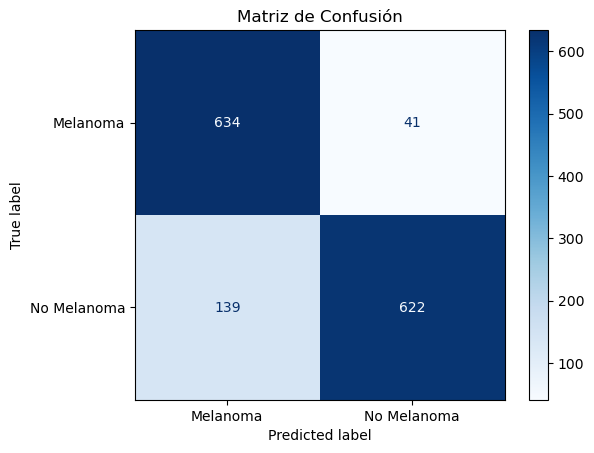

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(labels, predicted_classes)

# Mostrar la matriz de confusión
labels_names = ds['train'].features['label'].names  # Nombres de las clases
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de Confusión")
plt.show()


In [31]:
trainer.save_model()
trainer.save_state()
